## Условие задачи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Ситуация на рынке складывается такая, что из-за конкуренции мы начали фиксировать ощутимый отток клиентов. Было принято решение давать скидку абонентам для сохранения абонентской базы. Но так как финансовые ресурсы у нас ограничены, необходимо таргетировать скидку на бегунков.


### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

In [1]:
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer


In [5]:
import catboost as cb
from catboost import CatBoostClassifier, Pool
from catboost import MetricVisualizer
# from catboost.utils import get_roc_curve

print('CatBoost version {}'.format(cb.__version__))


CatBoost version 0.23.2


In [6]:
from IPython.display import Markdown, display
from IPython.display import display, HTML

def printmd(string):
    display(Markdown(string))

# def printmd(string, color=None):
#     colorstr = "<span style='color:{}'>{}</span>".format(color, string)
#     display(Markdown(colorstr))
    
    
def print_bold(msg):
    printmd('**{}**'.format(msg))

def print_italic(msg):
    printmd('*{}*'.format(msg))

def print_header(msg):
    printmd('### {}'.format(msg))


def print_table(df):
    # display(HTML(df.to_html()))
    display(df)

# print_bold('bold')
# print_italic('italic')
# print_header('header')

In [7]:
base_dir = ''
if not Path('.local').is_file():
    base_dir = '/datasets/final_provider/'
  
contract_data = pd.read_csv(base_dir + 'contract.csv')
internet_data = pd.read_csv(base_dir + 'internet.csv')
personal_data = pd.read_csv(base_dir + 'personal.csv')
phone_data = pd.read_csv(base_dir + 'phone.csv')

# Исследование данных

In [8]:
def prc_(a,b):
    return round(a/b*100,2)

## Информация о договоре

In [9]:
contract_data.shape

(7043, 8)

In [10]:
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [11]:
contract_data.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


In [12]:
print_bold('Количество ид клиентов в разных таблицах')
print('personal: {}\ncontract: {}\nphone: {}\ninternet: {}'.format(
    personal_data['customerID'].nunique(),
    contract_data['customerID'].nunique(),
    phone_data['customerID'].nunique(),
    internet_data['customerID'].nunique()
))
print_italic('Есть клиенты использующие услугу интернет и не использующие услугу телефон и наоборот')


**Количество ид клиентов в разных таблицах**

personal: 7043
contract: 7043
phone: 6361
internet: 5517


*Есть клиенты использующие услугу интернет и не использующие услугу телефон и наоборот*

In [13]:
contract_data['Cancel'] = 1
contract_data.loc[contract_data.query('EndDate=="No"').index, 'Cancel'] = 0
print_bold('Отказники')
print(contract_data['Cancel'].value_counts())
print_italic('Отказники это те у которых проставлена дата окончания договора.')

**Отказники**

0    5174
1    1869
Name: Cancel, dtype: int64


*Отказники это те у которых проставлена дата окончания договора.*

In [14]:
contract_data['BeginDate'] = pd.to_datetime(contract_data['BeginDate'])
contract_data['EndDate_'] = pd.to_datetime(contract_data['EndDate'], errors='coerce')

print_italic('Преобразование дат в тип "дата".')

*Преобразование дат в тип "дата".*

In [15]:
print('BeginDate from: {}\nBeginDate to: {}\nEndDate from: {}\nEndDate to: {}'.format(
contract_data['BeginDate'].min(),
    contract_data['BeginDate'].max(),
    contract_data['EndDate_'].min(),
    contract_data['EndDate_'].max(),
))

print_italic('Периоды дат начала гораздо шире дат окончания договора.')

BeginDate from: 2013-10-01 00:00:00
BeginDate to: 2020-02-01 00:00:00
EndDate from: 2019-10-01 00:00:00
EndDate to: 2020-01-01 00:00:00


*Периоды дат начала гораздо шире дат окончания договора.*

*Есть выброс в районе 2014-01 и увеленичение кол-ва договоров к концу 2019 года*

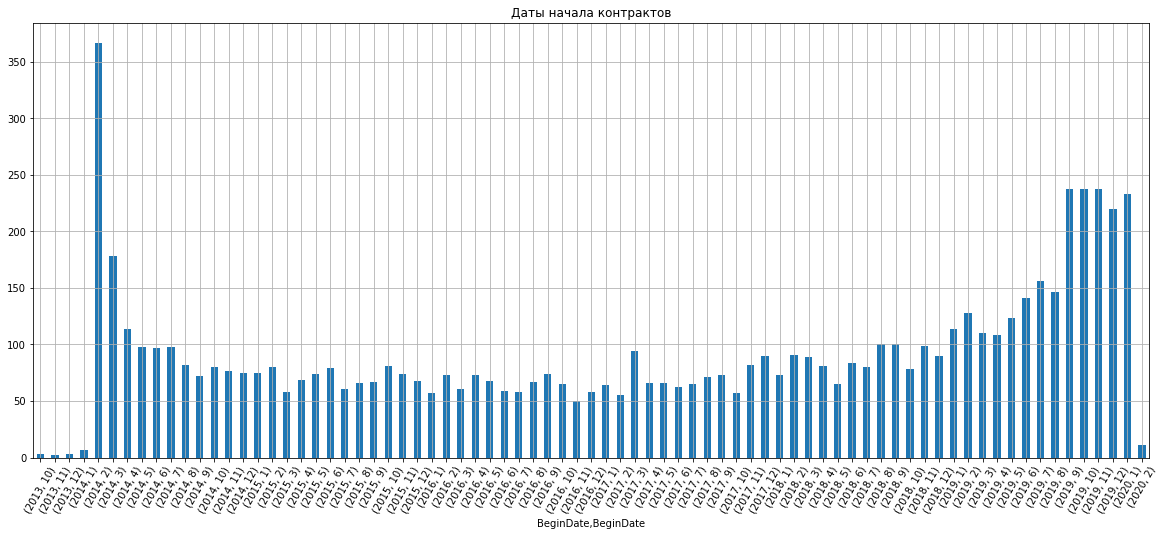

In [16]:
(
    contract_data
    .sort_values(by='BeginDate', ascending=True)
    .groupby([contract_data["BeginDate"].dt.year, contract_data["BeginDate"].dt.month])['BeginDate']
    .count()
    .plot(kind="bar", figsize=(20,8), rot=60, grid=True, title='Даты начала контрактов')
)

print_italic('Есть выброс в районе 2014-01 и увеленичение кол-ва договоров к концу 2019 года')

*Наглядно видно что закрытие договоров сосредоточено в 4 датах*

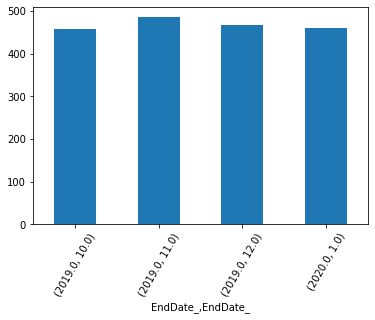

In [17]:
(
    contract_data
    .sort_values(by='EndDate_', ascending=True)
    .groupby([contract_data["EndDate_"].dt.year, contract_data["EndDate_"].dt.month])['EndDate_']
    .count()
    .plot(kind="bar", rot=60)
)

print_italic('Наглядно видно что закрытие договоров сосредоточено в 4 датах')

In [18]:
open_cnt = contract_data["BeginDate"].nunique()
close_cnt = contract_data["EndDate_"].nunique()

print('Уникальных дат начала договора: {}, уникальных дат окончания договора: {} ({}%)'.format(
    open_cnt,
    close_cnt,
    prc_(close_cnt, open_cnt)
))

Уникальных дат начала договора: 77, уникальных дат окончания договора: 4 (5.19%)


*Большая часть договоров отказников заключена за последние 6 месяцев*

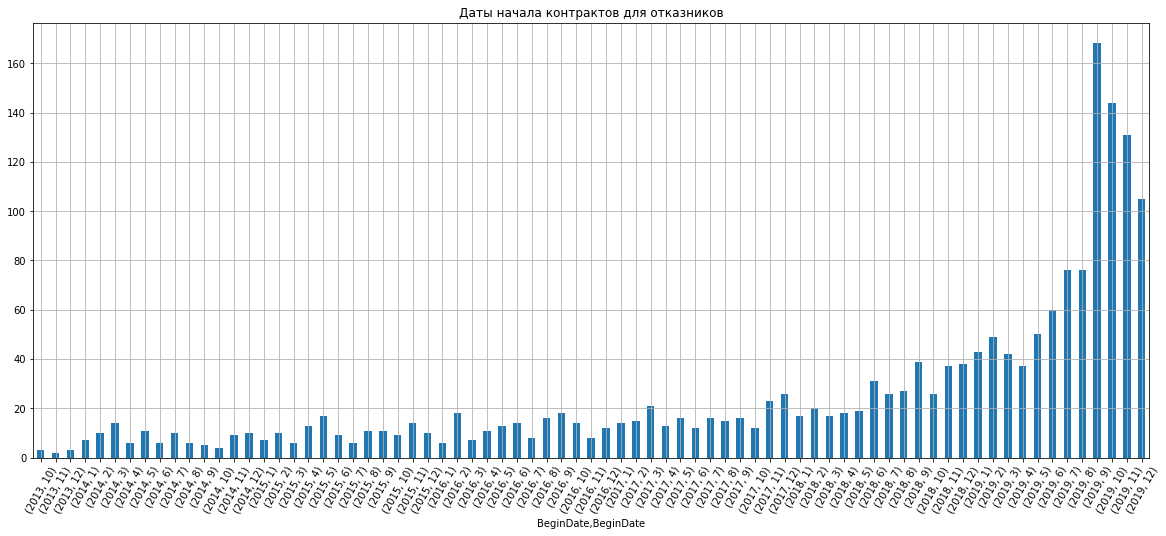

In [19]:
(
    contract_data
    .query('Cancel == 1')
    .sort_values(by='BeginDate', ascending=True)
    .groupby([contract_data["BeginDate"].dt.year, contract_data["BeginDate"].dt.month])['BeginDate']
    .count()
    .plot(kind="bar", figsize=(20,8), rot=60, grid=True, title='Даты начала контрактов для отказников')
)

print_italic('Большая часть договоров отказников заключена за последние 6 месяцев')

In [20]:
total = contract_data.query('Cancel == 1')['customerID'].count()
after = contract_data.query('Cancel == 1 and BeginDate >= "2019-06"')['customerID'].count()
before = contract_data.query('Cancel == 1 and BeginDate < "2019-06"')['customerID'].count()

print('Отказников с контрактам до 2019-06: {}, после 2019-06: {} ({}%)'.format(
    before,
    after,
    prc_(after, total)
))


Отказников с контрактам до 2019-06: 1109, после 2019-06: 760 (40.66%)


In [21]:
contract_data.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Cancel,EndDate_
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,NaT
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0,NaT
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,2019-12-01


In [22]:
print_header('Анализ возможных значений колонок')

cols = ['Type', 'PaymentMethod']
for col in cols:
    print_bold(col)
    print(contract_data[col].value_counts())

### Анализ возможных значений колонок

**Type**

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64


**PaymentMethod**

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64


In [23]:
print_header('Анализ пропущенных значений')

total = contract_data.shape[0]
for col in contract_data.columns:
    na = contract_data[contract_data[col].isna() == True].shape[0]
    prc = round(na/total*100, 2)
    print('NA {}: {} ({}%)'.format(col, na, prc))

### Анализ пропущенных значений

NA customerID: 0 (0.0%)
NA BeginDate: 0 (0.0%)
NA EndDate: 0 (0.0%)
NA Type: 0 (0.0%)
NA PaperlessBilling: 0 (0.0%)
NA PaymentMethod: 0 (0.0%)
NA MonthlyCharges: 0 (0.0%)
NA TotalCharges: 0 (0.0%)
NA Cancel: 0 (0.0%)
NA EndDate_: 5174 (73.46%)


In [24]:
contract_data = contract_data[contract_data['TotalCharges'].isna() == False]
contract_data = contract_data[contract_data['TotalCharges'] != ' ']
contract_data.loc[contract_data.index, 'TotalCharges'] = pd.to_numeric(contract_data['TotalCharges'])

print_italic('Преобразоване колонки TotalCharges к числу')


*Преобразоване колонки TotalCharges к числу*

In [25]:
contract_data['UsingDuration'] = 0

# Уже закончился срок обслуживания
idx = contract_data.query('EndDate_ == EndDate_').index
contract_data.loc[idx, 'UsingDuration'] = (
    (contract_data.loc[idx, 'EndDate_'] - contract_data.loc[idx, 'BeginDate'])/np.timedelta64(1, 'M')
)

# Еще наш клиент, беру максимальную дату на момент выгрузки - это 2020-01-01
date_to = contract_data.BeginDate.max()
idx = contract_data.query('EndDate_ != EndDate_').index
contract_data.loc[idx, 'UsingDuration'] = (
    (date_to - contract_data.loc[idx, 'BeginDate'])/np.timedelta64(1, 'M')
)

contract_data.loc[:, 'UsingDuration'] = round(contract_data['UsingDuration'])
contract_data.loc[:, 'UsingDuration'] = contract_data['UsingDuration'].astype('int64')

uniq_ = contract_data['UsingDuration'].nunique()
print_italic('Выделение колонки UsingDuration - кол-во месяцев использования. Уникальных значений: {}'.format(uniq_))


*Выделение колонки UsingDuration - кол-во месяцев использования. Уникальных значений: 73*

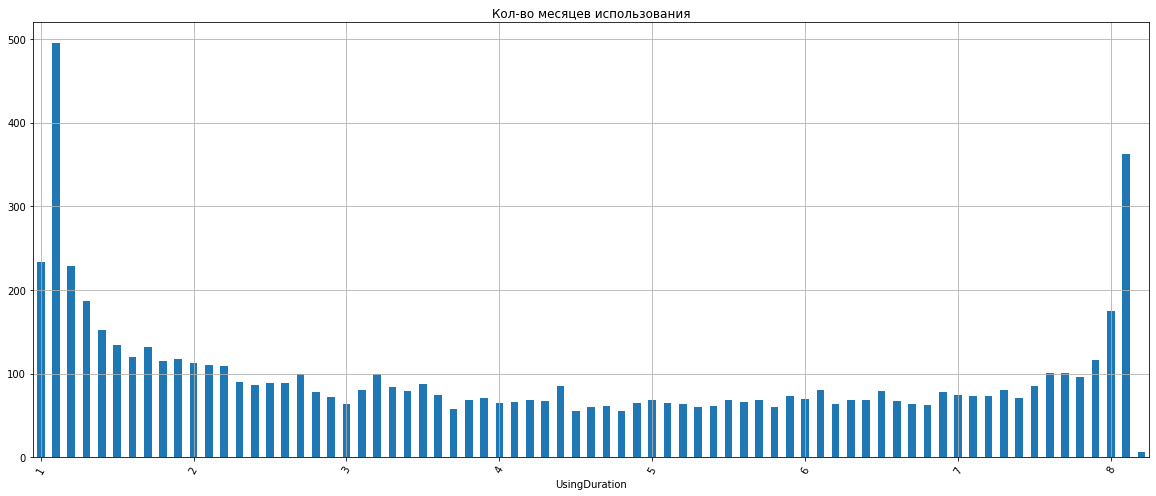

In [26]:

ax = (
    contract_data
    .groupby('UsingDuration')
    ['UsingDuration']
    .count()
    .plot(kind="bar", figsize=(20,8), rot=60, grid=True, title='Кол-во месяцев использования')
)

ax.xaxis.set_major_locator(ticker.AutoLocator())


### Анализ числовых значений

**MonthlyCharges**

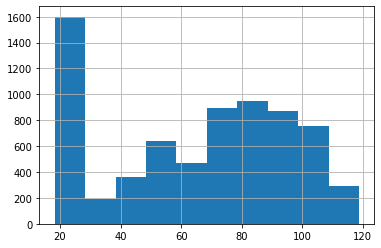

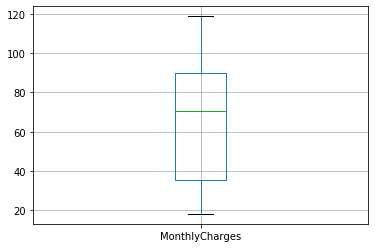

       MonthlyCharges
count     7032.000000
mean        64.798208
std         30.085974
min         18.250000
25%         35.587500
50%         70.350000
75%         89.862500
max        118.750000


**TotalCharges**

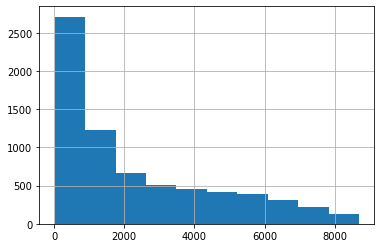

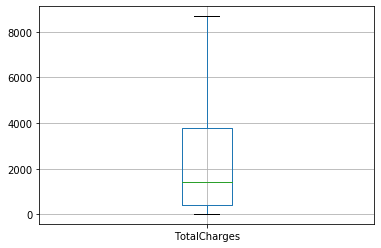

       TotalCharges
count   7032.000000
mean    2283.300441
std     2266.771362
min       18.800000
25%      401.450000
50%     1397.475000
75%     3794.737500
max     8684.800000


**UsingDuration**

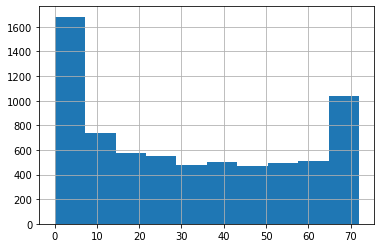

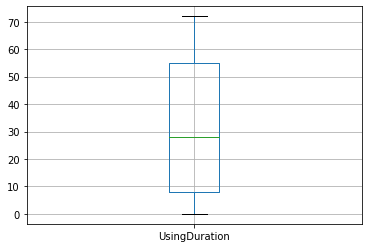

       UsingDuration
count    7032.000000
mean       31.687571
std        24.392347
min         0.000000
25%         8.000000
50%        28.000000
75%        55.000000
max        72.000000


In [27]:
print_header('Анализ числовых значений')

cols = ['MonthlyCharges', 'TotalCharges', 'UsingDuration']
for col in cols:
    print_bold(col)
    contract_data[col].hist()
    plt.show()
    contract_data[[col]].boxplot()
    plt.show()
    print(contract_data[[col]].describe())


_Выбросов нет._

MonthlyCharges
* mean        64.798208
* min         18.250000
* max        118.750000

TotalCharges
* mean    2283.300441
* min       18.800000
* max     8684.800000

UsingDuration
* mean       31.844568
* min         0.000000
* max        75.000000

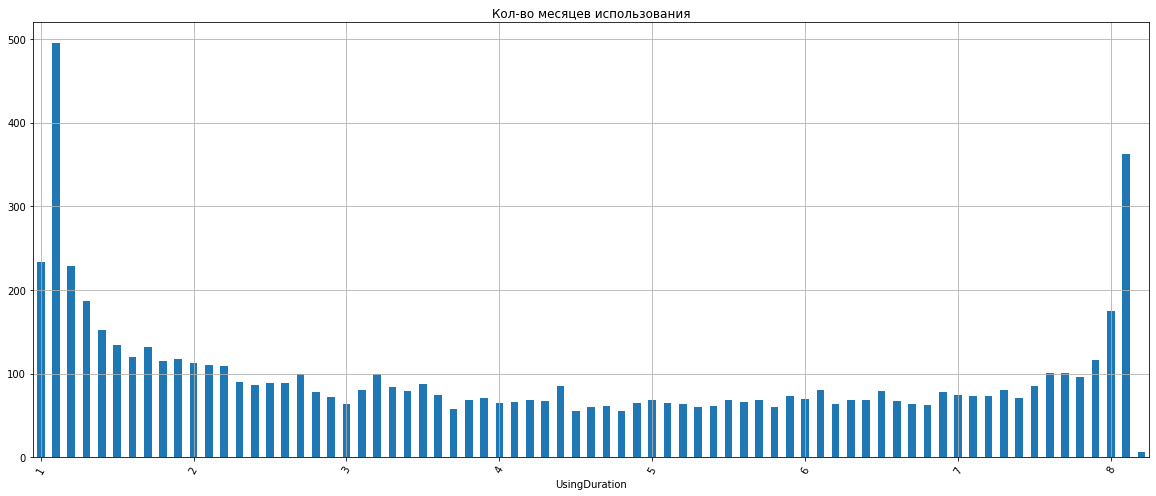

In [28]:
ax = (
    contract_data
    .groupby('UsingDuration')
    ['UsingDuration']
    .count()
    .plot(kind="bar", figsize=(20,8), rot=60, grid=True, title='Кол-во месяцев использования')
)

ax.xaxis.set_major_locator(ticker.AutoLocator())


In [29]:
print('Абонентов в среднем по месяцам: {}, абонентов с длительностью пользования 70 месяцев: {}'.format(
    round(contract_data['UsingDuration'].mean()),
    contract_data.query('UsingDuration == 70')['UsingDuration'].count()
))

Абонентов в среднем по месяцам: 32, абонентов с длительностью пользования 70 месяцев: 175


### Выводы

* 7043 - строк
* BeginDate, EndDate - приведен к datetime64
* TotalCharges - приведен к float

_Приведение BeginDate и EndDate к формату datetime64. Так как EndDate содержит текствое значение No, выделил в отдельную колонку в которое значение No приравнено к Nat_


Выделил признак Cancel - это контракты у которых проставлена дата EndDate

* 0    5174
* 1    1869

Получатся что даты начала договора у нас с 2013-10-01, даты окончания с 2020-01-01
* BeginDate from: 2013-10-01 00:00:00
* BeginDate to: 2020-02-01 00:00:00
* EndDate from: 2019-10-01 00:00:00
* EndDate to: 2020-01-01 00:00:00

Более того месяцы подключения распределены равномерно, а даты окончания сосредоточены в четырех датах.

* 2019-10-01    458
* 2019-11-01    485
* 2019-12-01    466
* 2020-01-01    460


__Значения колонок__

Type

* Month-to-month    3875
* Two year          1695
* One year          1473

PaymentMethod

* Electronic check             2365
* Mailed check                 1612
* Bank transfer (automatic)    1544
* Credit card (automatic)      1522

Тыц
* Половина клиентов клиентов предпочитает ежемесячные платежи. Платежи ежегодные и за два года делят пополам оставшихся клиентов;
* Чуть меньше половины пользуется автоматической оплатой


11 записей содержат TotalCharges == null, эти записи все за одну дату 2020-02-01, это последняя дата в данных. Видимо TotalCharges рассчитывается на конец месяца. Такие записи составляют 0,16% данных. Удалил их.

MonthlyCharges, TotalCharges, UsingDuration - не содержат выборосов.

MonthlyCharges
* mean        64.798208
* min         18.250000
* max        118.750000

TotalCharges
* mean    2283.300441
* min       18.800000
* max     8684.800000

UsingDuration
* mean       31.844568
* min         0.000000
* max        75.000000


Абонентов в среднем по месяцам: 32, абонентов с длительностью пользования 70 месяцев: 544

Отказников с контрактам до 2019-06: 1109, после 2019-06 760 (68.53%). Многие отказники это клиенты подключенные за послдение 6 месяцев.

## Персональные данные клиента

In [30]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [31]:
personal_data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


In [32]:
cols = personal_data.columns.to_list()
cols.remove('customerID')
for col in cols:
    print_bold(col)
    print(personal_data[col].value_counts())
    print()


**gender**

Male      3555
Female    3488
Name: gender, dtype: int64



**SeniorCitizen**

0    5901
1    1142
Name: SeniorCitizen, dtype: int64



**Partner**

No     3641
Yes    3402
Name: Partner, dtype: int64



**Dependents**

No     4933
Yes    2110
Name: Dependents, dtype: int64



## Выводы

* SeniorCitizen - пенсионер
* Partner	- супруг
* Dependents - дети

## Информация об интернет-услугах

In [33]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [34]:
internet_data.head(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


In [35]:
cols = internet_data.columns.to_list()
cols.remove('customerID')
for col in cols:
    print_bold(col)
    print(internet_data[col].value_counts())
    print()


**InternetService**

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64



**OnlineSecurity**

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64



**OnlineBackup**

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64



**DeviceProtection**

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64



**TechSupport**

No     3473
Yes    2044
Name: TechSupport, dtype: int64



**StreamingTV**

No     2810
Yes    2707
Name: StreamingTV, dtype: int64



**StreamingMovies**

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64



### Выводы

Все колонки содержать информацию да\нет по услуге. Колонка InternetService содержит информацию о типе соеденения.

## Информация об услугах телефонии

In [36]:
phone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [37]:
phone_data.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [38]:
phone_data['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

### Выводы

Колонка MultipleLines содержит информацию использует ли клиент возможность подключения телефонного аппарата к нескольким линиям одновременно.

## Полнота данных о пользователе

In [39]:
def print_nunique(title, df, col='customerID'):
    print('{}. Всего клиентов: {}, уникальных: {}'.format(
        title,
        df[col].count(),
        df[col].nunique()
    ))

print_nunique('contract', contract_data)
print_nunique('personal', personal_data)
print_nunique('internet', internet_data)
print_nunique('phone', phone_data)

print_italic('Все таблицы содержат данные по уникальным клиентам.')

contract. Всего клиентов: 7032, уникальных: 7032
personal. Всего клиентов: 7043, уникальных: 7043
internet. Всего клиентов: 5517, уникальных: 5517
phone. Всего клиентов: 6361, уникальных: 6361


*Все таблицы содержат данные по уникальным клиентам.*

In [40]:
df_internet = internet_data[['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']]
df_phone = (
    phone_data[['customerID', 'MultipleLines']]
    .rename(columns={"MultipleLines": "PhoneMultipleLines"})
)

df_personal_data = personal_data.rename(columns={'gender':'Gender'})

# SeniorCitizen на самом деле категориональный признак
# df_personal_data[df_personal_data.query('SeniorCitizen == 0').index, 'SeniorCitizen_'] = 'No'
# df_personal_data[df_personal_data.query('SeniorCitizen == 1').index, 'SeniorCitizen_'] = 'Yes'


flat_data = (
    contract_data[['customerID', 'Type',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Cancel', 'UsingDuration']]
    .rename(columns={"Type": "PaymentType"})
    .copy()
)

flat_data['TotalChargesCalc'] = flat_data['MonthlyCharges'] * flat_data['UsingDuration']
flat_data['Internet'] = 0
flat_data['InternetExtended'] = 0
flat_data['Phone'] = 0
flat_data['Family'] = 0

flat_data = flat_data.merge(df_internet, on='customerID', how='left')
flat_data = flat_data.merge(df_phone, on='customerID', how='left')
flat_data = flat_data.merge(df_personal_data, on='customerID', how='left')

# Есть инетик\телефон
flat_data.loc[flat_data.query('InternetService == InternetService').index, 'Internet'] = 1
flat_data.loc[flat_data.query('PhoneMultipleLines == PhoneMultipleLines').index, 'Phone'] = 1

# Пользуется расширенными интернет-услугами или нет
where = []
for col in ('OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'):
    where.append("{}=='Yes'".format(col))
flat_data.loc[flat_data.query(' or '.join(where)).index, 'InternetExtended'] = 1

flat_data = flat_data.fillna('Not used').copy()

# Семья
flat_data.loc[flat_data.query('Partner == "Yes" or Dependents == "Yes"').index, 'Family'] = 1


display(flat_data.head(3))
# print_italic('Создание таблицы содержащей только нужные для анализа данные')
# print('*', '\n* '.join(flat_data.columns.to_list()))

,customerID,PaymentType,PaymentMethod,MonthlyCharges,TotalCharges,Cancel,UsingDuration,TotalChargesCalc,Internet,InternetExtended,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PhoneMultipleLines,Gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Month-to-month,Electronic check,29.85,29.85,0,0,0.00,1,1,...,Yes,No,No,No,No,Not used,Female,0,Yes,No
1,5575-GNVDE,One year,Mailed check,56.95,1889.50,0,33,1879.35,1,1,...,No,Yes,No,No,No,No,Male,0,No,No
2,3668-QPYBK,Month-to-month,Mailed check,53.85,108.15,1,2,107.70,1,1,...,Yes,No,No,No,No,No,Male,0,No,No


In [41]:
print_header('Использованием услуг клиентом')

total = 0

segments_query = {
    'Без интернета, без телефона': "Internet != 1 and Phone != 1",
    'Без интернета, с телефоном': "Internet != 1 and Phone == 1",
    'С интернетом, без телефона': "Internet == 1 and Phone != 1",
    'С интернетом, с телефоном': "Internet == 1 and Phone == 1",
}

for title, query in segments_query.items():
    cnt = flat_data.query(query)['customerID'].count() 
    total += cnt
    print('* {}: {}'.format(
        title, 
        cnt
        
    ))
    
print('\nВсего по строкам: {}\nВсего фактически: {}'.format(
    flat_data.shape[0], 
    total
))

### Использованием услуг клиентом

* Без интернета, без телефона: 0
* Без интернета, с телефоном: 1520
* С интернетом, без телефона: 680
* С интернетом, с телефоном: 4832

Всего по строкам: 7032
Всего фактически: 7032


### Выводы

Все таблицы содержат данные по уникальным клиентам.

* contract. Всего клиентов: 7032, уникальных: 7032
* personal. Всего клиентов: 7043, уникальных: 7043
* internet. Всего клиентов: 5517, уникальных: 5517
* phone. Всего клиентов: 6361, уникальных: 6361


Создание таблицы содержащей только нужные для анализа данные.

Использованием услуг клиентом

* Без интернета, без телефона: 0
* Без интернета, с телефоном: 1520
* С интернетом, без телефона: 680
* С интернетом, с телефоном: 4832
* Всего по строкам: 7032
* Всего фактически: 7032


Если клиенты которые используют одну из услуг телефон или интернет. Таким образом у нас 3 базовых сегмента пользователей: 

* Без интернета, с телефоном
* С интернетом, без телефона
* С интернетом, с телефоном




# План работ

Базовые сегменты пользователей

* Без интернета, с телефоном
* С интернетом, без телефона
* С интернетом, с телефоном

Значимые данные для разделения пользователей на сегменты

* Объем услуг интернета - Internet, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies. Также выделил признак есть ли вообще доп-услуги: InternetExtended
* Объем услуг телефона - Phone, PhoneMultipleLines
* Тип оплаты: ежемесечно, ежегодно, за 2 года - PaymentType
* Метод оплаты - PaymentMethod
* Длительность пользования услугой - UsingDuration. Посчитал сумму платежей как произведение месяцев использования на сумму ежемесячного платежа. Это немного странная цифра, потому что в течении использования сервисом сумма ежемесячного платежа может менятся.
* Размер ежемесячного платежа - MonthlyCharges

Исключенные поля
* Cancel - признак отказник или нет
* Даты договора использую как длительность использования для расчета UsingDuration


# Отбор признаков и создание модели

In [42]:
def print_metrics(target_, predictions_, predictions_proba_, threshold=0.5):
    predictions_proba_ones_ = predictions_proba_[:, 1]
    predictions_threshold_ = np.where(predictions_proba_ones_>=threshold, 1, 0)

    # TN FP
    # FN TP
    # print('confusion_matrix:\n', confusion_matrix(target_, predictions))
    # print('* f1_score: {}\n* accuracy: {}\n* auc_roc: {}\n'.format(f1_score_, accuracy_, auc_roc_))
    
    scores = {}
    scores.update({'roc_auc_score': roc_auc_score(target_, predictions_)})
    scores.update({'accuracy_score': accuracy_score(target_, predictions_)})
    
    if threshold != 0.5:
        print('threshold:',threshold)
        scores.update({'roc_auc_score threshold': roc_auc_score(target_, predictions_threshold_)})
        scores.update({'accuracy_score threshold': accuracy_score(target_, predictions_threshold_)})
    
    scores.update({'recall_score': recall_score(target_, predictions_)})
    scores.update({'precision_score': precision_score(target_, predictions_)})
    # scores.update({'f1_score': f1_score(target_, predictions_)})
    
    
    for k, v in scores.items():
        msg = '{}: {}'.format(k, v)
        if k =='roc_auc_score':
            # print_bold(msg)
            printmd('{}: **{}**'.format(k, v))
        elif k =='accuracy_score':
            # print_italic(msg)
            printmd('{}: *{}*'.format(k, v))
        else:
            print(msg)

    return scores

# test
scores = print_metrics(
    np.array([0, 1, 0]), 
    np.array([1, 1, 0]), 
    np.array([[0.96115572, 0.03884428], [0.72743425, 0.27256575],[0.64515485, 0.35484515]])
)    
print(scores)

roc_auc_score: **0.75**

accuracy_score: *0.6666666666666666*

recall_score: 1.0
precision_score: 0.5
{'roc_auc_score': 0.75, 'accuracy_score': 0.6666666666666666, 'recall_score': 1.0, 'precision_score': 0.5}


In [43]:
# def roc_curve_draw(target_, predictions_proba_):
#     predictions_proba_ones_ = predictions_proba_[:, 1]

#     fpr, tpr, thresholds = roc_curve(target_, predictions_proba_ones_)

#     plt.figure()
#     plt.plot([0, 1], [0, 1], linestyle='--')

#     plt.step(fpr, tpr, where='post')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.ylim([0.0, 1.0])
#     plt.xlim([0.0, 1.0])
#     plt.title('ROC-кривая')
#     plt.show()

In [44]:
flat_data.head(3)

,customerID,PaymentType,PaymentMethod,MonthlyCharges,TotalCharges,Cancel,UsingDuration,TotalChargesCalc,Internet,InternetExtended,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PhoneMultipleLines,Gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Month-to-month,Electronic check,29.85,29.85,0,0,0.00,1,1,...,Yes,No,No,No,No,Not used,Female,0,Yes,No
1,5575-GNVDE,One year,Mailed check,56.95,1889.50,0,33,1879.35,1,1,...,No,Yes,No,No,No,No,Male,0,No,No
2,3668-QPYBK,Month-to-month,Mailed check,53.85,108.15,1,2,107.70,1,1,...,Yes,No,No,No,No,No,Male,0,No,No


In [45]:
cat_features = flat_data.dtypes[flat_data.dtypes == 'object'].index.to_list()
cat_features.extend(['Internet', 'InternetExtended', 'SeniorCitizen', 'Phone', 'Family'])
cat_features.remove('customerID')
target_feature = 'Cancel'
num_features = [i for i in flat_data.columns.to_list() if i not in cat_features + [target_feature]]
num_features.remove('customerID')

print_bold('Категориональные признаки')
print(', '.join(cat_features))
print()
print_bold('Числовые признаки')
print(', '.join(num_features))
print()
print_bold('Целевой признак')
print(target_feature)


**Категориональные признаки**

PaymentType, PaymentMethod, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, PhoneMultipleLines, Gender, Partner, Dependents, Internet, InternetExtended, SeniorCitizen, Phone, Family



**Числовые признаки**

MonthlyCharges, TotalCharges, UsingDuration, TotalChargesCalc



**Целевой признак**

Cancel


In [46]:
print_header('Корреляция числовых признаков')

flat_data[num_features].corr()

### Корреляция числовых признаков

,MonthlyCharges,TotalCharges,UsingDuration,TotalChargesCalc
MonthlyCharges,1.000000,0.651065,0.251902,0.649942
TotalCharges,0.651065,1.000000,0.827445,0.999475
UsingDuration,0.251902,0.827445,1.000000,0.828919
TotalChargesCalc,0.649942,0.999475,0.828919,1.000000


Вижу взаимную корреляцию `TotalChargesCalc <-> TotalCharges` и `TotalChargesCalc <-> UsingDuration`.

Корреляцияя `TotalChargesCalc <-> TotalCharges= 0.999476`, убрал этот признак.

In [47]:
print_header('Удаление признаков с сильной взаимной корреляцией')

if 'TotalChargesCalc' in flat_data.columns.to_list():
    flat_data.drop(columns=['TotalChargesCalc'], inplace=True)

if 'TotalChargesCalc' in num_features:
    num_features.remove('TotalChargesCalc')

display(flat_data.head(3))
print_bold('Числовые признаки')
print(', '.join(num_features))
print()

### Удаление признаков с сильной взаимной корреляцией

,customerID,PaymentType,PaymentMethod,MonthlyCharges,TotalCharges,Cancel,UsingDuration,Internet,InternetExtended,Phone,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PhoneMultipleLines,Gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Month-to-month,Electronic check,29.85,29.85,0,0,1,1,0,...,Yes,No,No,No,No,Not used,Female,0,Yes,No
1,5575-GNVDE,One year,Mailed check,56.95,1889.50,0,33,1,1,1,...,No,Yes,No,No,No,No,Male,0,No,No
2,3668-QPYBK,Month-to-month,Mailed check,53.85,108.15,1,2,1,1,1,...,Yes,No,No,No,No,No,Male,0,No,No


**Числовые признаки**

MonthlyCharges, TotalCharges, UsingDuration



### Анализ влияния количественных и на целевой

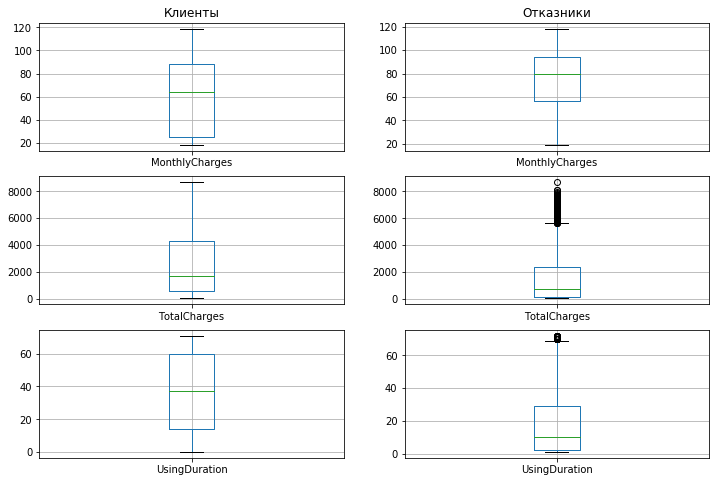

In [48]:
print_header('Анализ влияния количественных и на целевой')

fig, axes = plt.subplots(len(num_features), 2, sharex=False, sharey=False, figsize=(12, 8))

axes.flatten()[0].set_title('Клиенты')
axes.flatten()[1].set_title('Отказники')

for i, num_feature in enumerate(num_features):
    flat_data.query('Cancel == 0').boxplot(column=num_feature, ax=axes[i][0])
    flat_data.query('Cancel == 1').boxplot(column=num_feature, ax=axes[i][1])


_На графиках видно что распределение данных для клиентов и отказников разное. Делаю вывод что признаки имеют значение._

In [49]:
cat_features = flat_data.dtypes[flat_data.dtypes == 'object'].index.to_list()
cat_features.extend(['Internet', 'InternetExtended', 'SeniorCitizen', 'Phone', 'Family'])
cat_features.remove('customerID')
target_feature = 'Cancel'
num_features = [i for i in flat_data.columns.to_list() if i not in cat_features + [target_feature]]
num_features.remove('customerID')

print_bold('Категориональные признаки')
print(', '.join(cat_features))
print()
print_bold('Числовые признаки')
print(', '.join(num_features))
print()
print_bold('Целевой признак')
print(target_feature)


**Категориональные признаки**

PaymentType, PaymentMethod, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, PhoneMultipleLines, Gender, Partner, Dependents, Internet, InternetExtended, SeniorCitizen, Phone, Family



**Числовые признаки**

MonthlyCharges, TotalCharges, UsingDuration



**Целевой признак**

Cancel


In [50]:
print_header('Кодирование категориональных признаков')

flat_data_ohe = pd.get_dummies(flat_data.drop(columns=['customerID']), columns=cat_features, drop_first=True)
display(flat_data_ohe.head(3))


### Кодирование категориональных признаков

,MonthlyCharges,TotalCharges,Cancel,UsingDuration,PaymentType_One year,PaymentType_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,...,PhoneMultipleLines_Not used,PhoneMultipleLines_Yes,Gender_Male,Partner_Yes,Dependents_Yes,Internet_1,InternetExtended_1,SeniorCitizen_1,Phone_1,Family_1
0,29.85,29.85,0,0,0,0,0,1,0,0,...,1,0,0,1,0,1,1,0,0,1
1,56.95,1889.50,0,33,1,0,0,0,1,0,...,0,0,1,0,0,1,1,0,1,0
2,53.85,108.15,1,2,0,0,0,0,1,0,...,0,0,1,0,0,1,1,0,1,0


## Подготовка данных

In [51]:
target = flat_data_ohe['Cancel']
# features = flat_data_ohe.drop(['Cancel', 'UsingDuration', 'TotalChargesCalc'], axis=1)
features = flat_data_ohe.drop(['Cancel'], axis=1)


features_train, features_temp, target_train, target_temp = (
    train_test_split(features, target, test_size=0.20, random_state=12345)
)

features_test, features_valid, target_test, target_valid = (
    train_test_split(features_temp, target_temp, test_size=0.5, random_state=12345)
)

print('Разделение на обучаюшую \ тестовую \ валидационную выборки.')
print()

train_cnt = target_train.shape[0]
test_cnt =  target_test.shape[0]
valid_cnt = target_valid.shape[0]
total = train_cnt + test_cnt + valid_cnt

print_bold('Обучающая выборка {}%'.format(prc_(train_cnt, total)))
display(target_train.value_counts())

print_bold('Тестовая {}%'.format(prc_(test_cnt, total)))
display(target_test.value_counts())

print_bold('Валидационная {}%'.format(prc_(valid_cnt, total)))
display(target_valid.value_counts())

Разделение на обучаюшую \ тестовую \ валидационную выборки.



**Обучающая выборка 79.99%**

0    4139
1    1486
Name: Cancel, dtype: int64

**Тестовая 10.0%**

0    495
1    208
Name: Cancel, dtype: int64

**Валидационная 10.01%**

0    529
1    175
Name: Cancel, dtype: int64

In [52]:
scale_pos_weight_ = ((target.count() - target.sum()) / target.sum())

print_bold('Дисбаланс классов: {}'.format(scale_pos_weight_))
display(target.value_counts())

**Дисбаланс классов: 2.7624398073836276**

0    5163
1    1869
Name: Cancel, dtype: int64

## Выводы

**Обучение \ тест \ валидация**
* Обучающая выборка 89.99%
* Тестовая 5.01%
* Валидационная 5.01%

Если брать 20% данных на тест\валидацию результаты обучения моделей сохраняются. Если в обучающем наборе оставить меньше 25% данных - качество падает.


**Признаки**
* Категориональные признаки: PaymentType, PaymentMethod, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, PhoneMultipleLines, Gender, Partner, Dependents, Internet, InternetExtended, SeniorCitizen, Phone
* Числовые признаки: customerID, MonthlyCharges, TotalCharges, UsingDuration, TotalChargesCalc
* Целевой признак: Cancel


**Корреляция признаков с целевым (топ 3 с головы и с хвоста)**
* UsingDuration               -0.338314
* PaymentType_Two year        -0.301552
* DeviceProtection_Not used   -0.227578

* Internet_1                        0.227578
* PaymentMethod_Electronic check    0.301455
* InternetService_Fiber optic       0.307463

Я вообще не уверен что для признаков со значениями 0\1\2 можно делать корреляцию с бинарным целевым признаком. Думал поискать потом подтверждения и сделат выводы, но пока не сделал.


**Дисбаланс классов: 2.7624398073836276**

* 0    5163
* 1    1869



## Тестирование модели LogisticRegression

In [53]:
results = []
# results.append({'name':'test', 'roc_auc_score': 0,'accuracy_score': 0 })
# results

In [54]:
model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=12345)
model.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

In [55]:
predictions = model.predict(features_test)
predictions_proba = model.predict_proba(features_test)
print_bold('LogisticRegression test')
scores = print_metrics(target_test, predictions, predictions_proba)
# roc_curve_draw(target_test, predictions_proba)
print()

results.append({
    'name': 'LogisticRegression test', 
    'roc_auc_score': scores['roc_auc_score'],
    'accuracy_score': scores['accuracy_score'],
    'recall_score': scores['recall_score'],
    'precision_score': scores['precision_score']
})


**LogisticRegression test**

roc_auc_score: **0.7496454933954935**

accuracy_score: *0.7396870554765291*

recall_score: 0.7740384615384616
precision_score: 0.5420875420875421



## Тестирование модели DecisionTreeClassifier

In [56]:
%%time

# best_params_: {
#     'random_state': 42, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1,
#     'max_features': 'sqrt', 'max_depth': 10, 'class_weight': 'balanced', 'bootstrap': False}
# grid_search: 0.8729879732957301
# CPU times: user 26min 25s, sys: 4.25 s, total: 26min 29s
# Wall time: 26min 56s

param_search = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 100, None],
    'max_features': ['auto', 'log2', None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [50, 100, 200, 300, 500, 1000, 1500, 2000],
    'class_weight':['balanced'],
    'random_state': [42]
}


# def my_custom_loss_func(y_true, y_pred):
#     print('roc_auc_score: ', roc_auc_score(y_true, y_pred))
#     return roc_auc_score(y_true, y_pred)
# custom_scorer = make_scorer(my_custom_loss_func, greater_is_better=False)


# search_ = GridSearchCV(
#     estimator = RandomForestClassifier(class_weight='balanced', random_state=42), 
#     scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}, 
#     refit='AUC', 
#     return_train_score=True,
#     param_grid = param_search,  
#     cv = 3, 
#     n_jobs = -1, 
#     verbose = 2
# )



search_ = RandomizedSearchCV(
    estimator = RandomForestClassifier(), 
    scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}, 
    refit='AUC', 
    return_train_score=True,
    param_distributions = param_search,  
    cv = 3, 
    n_jobs = -1, 
    verbose = 2,
    n_iter = 100
)


# search_.fit(features_train, target_train)
# print('best_params_:', search_.best_params_)
# print('grid_search:', search_.best_score_)


Wall time: 0 ns


In [57]:
%%time

# params = {
#     'random_state': 42, 'n_estimators': 300, 'min_samples_split': 8,
#     'min_samples_leaf': 3, 'max_depth': 10, 'bootstrap': False, 
#     'class_weight': 'balanced'
# }

params = {
    'random_state': 42, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1,
    'max_features': 'auto', 'max_depth': 10, 'class_weight': 'balanced', 'bootstrap': False
}

model = RandomForestClassifier(**params)
model.fit(features_train, target_train)

Wall time: 1.9 s


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [58]:
predictions = model.predict(features_test)
predictions_proba = model.predict_proba(features_test)
print_bold('RandomForestClassifier test')
scores = print_metrics(target_test, predictions, predictions_proba)
# roc_curve_draw(target_test, predictions_proba)
print()

results.append({
    'name': 'RandomForestClassifier test', 
    'roc_auc_score': scores['roc_auc_score'],
    'accuracy_score': scores['accuracy_score'],
    'recall_score': scores['recall_score'],
    'precision_score': scores['precision_score']    
})


**RandomForestClassifier test**

roc_auc_score: **0.7991792929292928**

accuracy_score: *0.7937411095305832*

recall_score: 0.8125
precision_score: 0.6145454545454545



## Тестирование модели CatBoost

In [59]:
train_pool = Pool(features_train, label=target_train)
test_pool = Pool(features_test, label=target_test)
valid_pool = Pool(features_valid, label=target_valid)

In [60]:
%%time

# 17:	loss: 0.9284646	best: 0.9284646 (17)	total: 9m 16s	remaining: 37m 6s

# {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}
# CPU times: user 51.4 s, sys: 6.4 s, total: 57.8 s
# Wall time: 1min 6s
    
# grid = {
#     'learning_rate': [0.03, 0.01, 0.1],
#     # 'l2_leaf_reg': [1, 3, 5, 7, 9],
#     'max_depth': [2, 4, 6, 10],
#     # 'iterations': [100, 500, 1000, 2000, 2500, 3000]
#     'iterations': [100]
# }


# {'depth': 6, 'iterations': 1000, 'learning_rate': 0.1}
# CPU times: user 5min 31s, sys: 35.2 s, total: 6min 6s
# Wall time: 7min 37s

# grid = {
#     'learning_rate': [0.1],
#     'max_depth': [6],
#     'iterations': [100, 500, 1000, 2000, 2500, 3000]
# }


# {'depth': 4, 'iterations': 1000, 'learning_rate': 0.1}
# CPU times: user 5min 52s, sys: 36.7 s, total: 6min 29s
# Wall time: 8min 3s

grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [4, 6],
    'iterations': [1000, 2000]
}

gs_model = CatBoostClassifier(
    # custom_loss=['Logloss', 'AUC'],
    loss_function= 'Logloss', 
    eval_metric='AUC',
    scale_pos_weight = scale_pos_weight_,
    random_seed=42
)


# grid_search_results = gs_model.grid_search(
#     grid, 
#     train_pool, 
#     shuffle=False, 
#     verbose=1, 
#     plot=False
# )
# print(grid_search_results['params'])



Wall time: 0 ns


In [61]:
%%time

# roc_auc_score: 0.8372183372183373
# params = {'depth': 4, 'iterations': 2000, 'learning_rate': 0.01}

# roc_auc_score: 0.8477661227661226
# params = {'depth': 6, 'iterations': 1000, 'learning_rate': 0.1}

# roc_auc_score: 0.86497668997669
params = {'depth': 4, 'iterations': 1000, 'learning_rate': 0.1}


model = CatBoostClassifier(
    # Metric values to output during training. 
    # These functions are not optimized and are displayed for informational purposes only
    # custom_metric=['AUC:hints=skip_train~false', 'Logloss'],
    
    # The metric to use in training. The specified value also determines the machine learning problem to solve. 
    loss_function= 'Logloss', 
    
    # The metric used for overfitting detection (if enabled) and best model selection (if enabled).
    eval_metric='AUC',
    
    use_best_model=True,
    scale_pos_weight = scale_pos_weight_,
    random_seed=42,
    verbose=100,
    train_dir='baseline',
    **params
)

model.fit(
    train_pool, 
    eval_set=test_pool
)

print(model.tree_count_)


0:	test: 0.7831925	best: 0.7831925 (0)	total: 62ms	remaining: 1m 1s
100:	test: 0.8878788	best: 0.8885198 (97)	total: 765ms	remaining: 6.81s
200:	test: 0.9018260	best: 0.9018260 (200)	total: 1.47s	remaining: 5.85s
300:	test: 0.9042444	best: 0.9050602 (270)	total: 2.11s	remaining: 4.9s
400:	test: 0.9054973	best: 0.9068085 (363)	total: 2.81s	remaining: 4.2s
500:	test: 0.9070804	best: 0.9075369 (492)	total: 3.42s	remaining: 3.41s
600:	test: 0.9085567	best: 0.9087510 (589)	total: 4s	remaining: 2.65s
700:	test: 0.9080614	best: 0.9091298 (606)	total: 4.6s	remaining: 1.96s
800:	test: 0.9068667	best: 0.9091298 (606)	total: 5.14s	remaining: 1.28s
900:	test: 0.9078380	best: 0.9091298 (606)	total: 5.68s	remaining: 624ms
999:	test: 0.9074106	best: 0.9091298 (606)	total: 6.16s	remaining: 0us

bestTest = 0.9091297591
bestIteration = 606

Shrink model to first 607 iterations.
607
Wall time: 6.46 s


In [62]:
print_bold('CatBoostClassifier test')
predictions = model.predict(features_test)
predictions_proba = model.predict_proba(features_test)
scores = print_metrics(target_test, predictions, predictions_proba)
print()

results.append({
    'name': 'CatBoostClassifier test', 
    'roc_auc_score': scores['roc_auc_score'],
    'accuracy_score': scores['accuracy_score'],
    'recall_score': scores['recall_score'],
    'precision_score': scores['precision_score']    
})

best_model = model

**CatBoostClassifier test**

roc_auc_score: **0.824674630924631**

accuracy_score: *0.833570412517781*

recall_score: 0.8028846153846154
precision_score: 0.6872427983539094



In [63]:
for result in results:
    for k,v in result.items():
        print('* {}: {}'.format(k,v))
    print()
        

* name: LogisticRegression test
* roc_auc_score: 0.7496454933954935
* accuracy_score: 0.7396870554765291
* recall_score: 0.7740384615384616
* precision_score: 0.5420875420875421

* name: RandomForestClassifier test
* roc_auc_score: 0.7991792929292928
* accuracy_score: 0.7937411095305832
* recall_score: 0.8125
* precision_score: 0.6145454545454545

* name: CatBoostClassifier test
* roc_auc_score: 0.824674630924631
* accuracy_score: 0.833570412517781
* recall_score: 0.8028846153846154
* precision_score: 0.6872427983539094



In [64]:
pd.DataFrame(data=results, columns=results[0].keys()).sort_values(by='roc_auc_score', ascending=True)


,name,roc_auc_score,accuracy_score,recall_score,precision_score
0,LogisticRegression test,0.749645,0.739687,0.774038,0.542088
1,RandomForestClassifier test,0.799179,0.793741,0.812500,0.614545
2,CatBoostClassifier test,0.824675,0.833570,0.802885,0.687243


## Выводы

### LogisticRegression test
* roc_auc_score: 0.7472416472416473
* accuracy_score: 0.7382645803698435

Дополнительно
* Борьба с дисбалансом: параметр class_weight='balanced'


### RandomForestClassifier test
* roc_auc_score: 0.7879273504273505
* accuracy_score: 0.7837837837837838

Дополнительно
* Борьба с дисбалансом: параметр class_weight='balanced'
* Подбор гиперпараметров:  RandomizedSearchCV
* Обучающая метрика: scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
* Выбор лучшей модели: refit='AUC'

### CatBoostClassifier test
* roc_auc_score: 0.8336247086247085
* accuracy_score: 0.8520625889046942

Дополнительно
* Борьба с дисбалансом: параметр scale_pos_weight
* Подбор гиперпараметров: grid_search
* Обучающая метрика: loss_function= 'Logloss'
* Выбор лучшей модели: eval_metric='AUC'

Для CatBoost попробовал скормить сырые данные без преобразование категориональных признаков, с указанием параметра cat_futures в Pool. Результаты моделей оказались примерно сопоставимы.

#### Итого
CatBoostClassifier показывает лучшие результаты на тестовом наборе данных.

# Тестирование лучшей модели на валидационной выборке

In [65]:
print_bold('CatBoostClassifier valid')
predictions = best_model.predict(features_valid)
predictions_proba = best_model.predict_proba(features_valid)
print_metrics(target_valid, predictions, predictions_proba)
print()


**CatBoostClassifier valid**

roc_auc_score: **0.8234188495814205**

accuracy_score: *0.8380681818181818*

recall_score: 0.7942857142857143
precision_score: 0.6405529953917051



In [66]:
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,UsingDuration,29.692393
1,TotalCharges,26.324422
2,MonthlyCharges,16.829238
3,PaymentType_Two year,5.704990
4,InternetService_Fiber optic,3.860767
5,PaymentType_One year,2.522121
6,PaymentMethod_Electronic check,1.326426
7,OnlineSecurity_Yes,1.148007
8,StreamingMovies_Yes,1.001846
9,TechSupport_Yes,0.852707


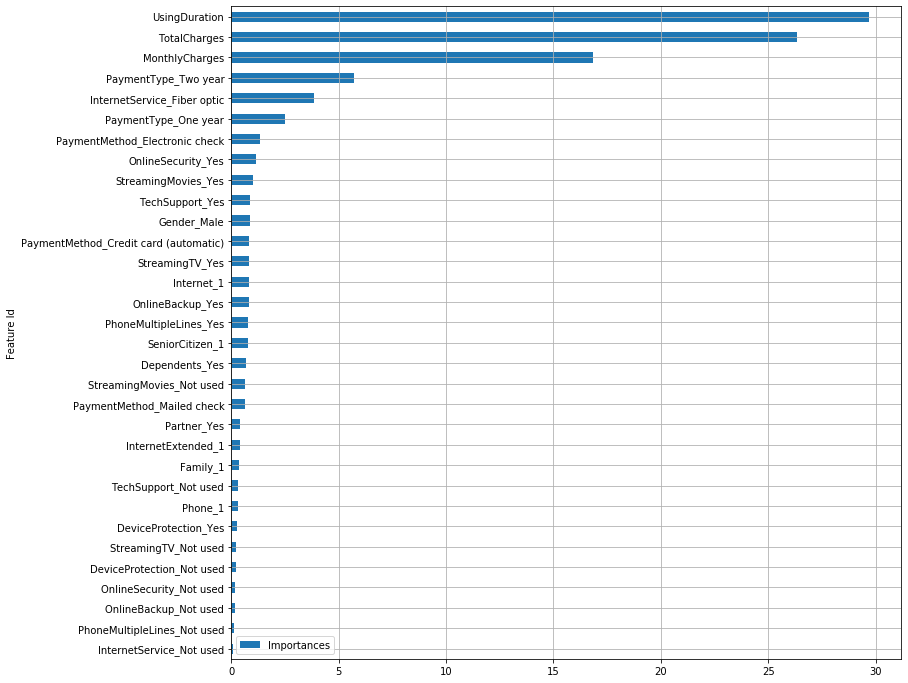

In [67]:
(
    best_model.get_feature_importance(prettified=True).sort_values(by='Importances', ascending=True)
    .plot(kind='barh', x='Feature Id', y='Importances', grid=True, figsize=(12, 12))
)

## Выводы

**Важность факторов**

`0	UsingDuration	36.661596
1	TotalCharges	23.546103
2	MonthlyCharges	15.792774
3	PaymentType_Two year	5.142844
4	InternetService_Fiber optic	2.952988
5	PaymentType_One year	2.102582`


**Какие пункты плана были выполнены, а какие — нет (поясните почему)?**
* Как и ожидалось UsingDuration, TotalCharges, MonthlyCharges - оказались значимыми признаками
* Я ожидал большего влияния сопутвующих услуг интернета.
* После консультации думал что сроляют семейное положение, наличие детей, статус пенсионера

**Какие трудности возникли и как вы их преодолели?**
* Нужно было быть внимательным при создании признака UsingDuration. Это вопрос формирования запросов;
* Была ошибка в функции подсчета метрик. Переменная протекала из глобальной области видимости. Иногда не быстро получается найти что не так;
* С графиками повозился как всегда. В частности тики;
* С Catboost повозился с пониманием как передать параметр несбалансированной выборки;
* Подбор гиперпараметров занимает много времени. И фактически у меня нет понимания как найти с чего начать перебор и как сужать кол-во проверяемых вариантов.

Все проблемы решались чтением документации, стековерфлоу и внимательным просмотром кода.

**Какие ключевые шаги в решении задачи выделили?**

В целом я не удовлетворен полученным результатом. Как я понимаю нужно было еще попробовать нейронные сети. Мне очень интересно как можно добиться большего c CatBoost.

У меня получилась общая схема, но именно она привела к результату.

1. Понимание данных (этот пункт можно два раза написать);
2. Убедится что данные чистые;
3. Посмотреть внутрь данных (сводные таблицы, графики);
4. Организовать код так чтобы эксперименты можно было перезапускать много раз;
5. Все повторяющиеся операции выделить в функции;
6. Для каждого этапа выделять свои переменные: сырые данные, предобработка, плоская таблица признаков, кодированная таблица признаков, разбиение обучение\тест\валидация. Для CatBoost выделение Pool. В этом случае всегда можно посмотреть на данные предыдущего этапа и провести дополнительное исследование;
7. Начинать с простых моделей;
8. Подбор гиперпараметров;
9. Заглядывать внутрь получаемых моделей. В этом я не мастер;
10. Последнее но важное, комментарии по ходу работы и выводы по каждому большому этапу. Мне это помогает самому прояснять требования к задаче.


Отдельно выделю
* Понимание что выборка несбалансирована, не терять это знание на этапе обучения моделей
* Внимание к тому по каким параметрам учится модель. LogLoss, AUG

**Какая ваша итоговая модель и какое у неё качество?**

CatBoostClassifier на валидационной выборке в 10% данных

* roc_auc_score: 0.8234188495814205
* accuracy_score: 0.8380681818181818
* recall_score: 0.7942857142857143
* precision_score: 0.64055299539170517


